### Implementing Few Shot Learning

References:

- https://www.kaggle.com/martinpiotte/whale-recognition-model-with-score-0-78563
- https://docs.fast.ai/tutorial.itemlist.html

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path

import fastai
from fastai import *
from fastai.vision import *
from ipyexperiments import *

fastai.__version__

'1.0.41'

In [3]:
data_path = Path('../data/whale/')

In [4]:
sorted(data_path.ls())

[PosixPath('../data/whale/cropped_test'),
 PosixPath('../data/whale/cropped_training'),
 PosixPath('../data/whale/models'),
 PosixPath('../data/whale/submissions'),
 PosixPath('../data/whale/test'),
 PosixPath('../data/whale/test_csv_2.csv'),
 PosixPath('../data/whale/train'),
 PosixPath('../data/whale/train.csv'),
 PosixPath('../data/whale/train_csv_2.csv')]

In [5]:
train_df = pd.read_csv(data_path/'train.csv')

In [6]:
train_df.head()

,Image,Id
0,0000e88ab.jpg,w_f48451c
1,0001f9222.jpg,w_c3d896a
2,00029d126.jpg,w_20df2c5
3,00050a15a.jpg,new_whale
4,0005c1ef8.jpg,new_whale


In [7]:
# whale id image counts - number of whale ids with only single image
w_counts = train_df.groupby(['Id'])['Id'].count().sort_values(ascending=False)
print(f"number of whale ids with single image: {sum(w_counts == 1)}")
print(f"number of unique whale ids in training: {len(w_counts)}")
w2counts = dict(w_counts)
counts2w = {w2counts[k]:k for k in w2counts}
w2fnames = dict(train_df.groupby(['Id'])['Image'].apply(lambda x: list(x)))

number of whale ids with single image: 2073
number of unique whale ids in training: 5005


In [8]:
list(w2fnames.items())[-5:]

[('w_ff94900', ['5ac086036.jpg']),
 ('w_ffa542b', ['4f9e431aa.jpg', '8abea550e.jpg', 'cd3a073a2.jpg']),
 ('w_ffa6d42', ['9dd320bb3.jpg']),
 ('w_ffcf5fe', ['d3967e1df.jpg']),
 ('w_ffe8693', ['df4bbd82a.jpg'])]

In [9]:
# classes
idx2w = dict(enumerate(w2counts.keys()))
w2idx = {idx2w[k]:k for k in idx2w}
classes = list(w2counts.keys())

In [10]:
# Validation fnames
np.random.seed(42)
train_fnames = []
valid_fnames = []
val_ratio = 0.1
for _, fnames in w2fnames.items():
    if len(fnames) == 1:
        train_fnames += fnames
    else:
        n = len(fnames)
        n_val = max(1, int(n*val_ratio)) 
        fnames = np.random.permutation(fnames)
        train_fnames += list(fnames[n_val:])
        valid_fnames += list(fnames[:n_val])

len(train_fnames), len(valid_fnames)

training_df = train_df[train_df.Image.isin(train_fnames)].reset_index(drop=True)
validation_df = train_df[train_df.Image.isin(valid_fnames)].reset_index(drop=True)

print(f"unique classes in train : {training_df['Id'].nunique()}")
print(f"unique classes in valid: {validation_df['Id'].nunique()}")
print(f"unique classes with single image: {training_df['Id'].nunique() - validation_df['Id'].nunique()}")

unique classes in train : 5005
unique classes in valid: 2932
unique classes with single image: 2073


### Pair Image Databunch

In [11]:
class ImageTuple(ItemBase):
    def __init__(self, img1, img2):
        self.img1,self.img2 = img1,img2
        self.obj,self.data = (self.img1,self.img2),[self.img1.data,self.img2.data]
        self.stats = torch.tensor(imagenet_stats)
        
    def apply_tfms(self, tfms, **kwargs):
        self.img1 = self.img1.apply_tfms(tfms, **kwargs)
        self.img2 = self.img2.apply_tfms(tfms, **kwargs)
        self.data = [self.img1.data,self.img2.data]
        self.data = [normalize(t, *self.stats) for t in self.data]
        return self
    
    def to_one(self): 
        """rather than in reconstruct() denormalizations for show methods happen here"""
        return Image(torch.cat([denormalize(t, *self.stats) for t in self.data],2))
    
    def __repr__(self):
        return f'{self.__class__.__name__}{(self.img1.shape, self.img2.shape)}'
        

In [12]:
class ImageTupleList(ImageItemList):
#     _label_cls=TargetTupleList
    def __init__(self, items, **kwargs):
        """items should be tuple of image paths"""
        super().__init__(items, **kwargs)
    
    def get(self, i):
        fn1, fn2 = self.items[i]
        img1, img2 = open_image(fn1), open_image(fn2)
        return ImageTuple(img1, img2)
    
    def reconstruct(self, t:Tensor): 
        return ImageTuple(Image(t[0]),Image(t[1]))
    
    @classmethod
    def from_folders(cls, path, folderA, folderB, **kwargs):
        itemsB = ImageItemList.from_folder(path/folderB).items
        res = super().from_folder(path/folderA, itemsB=itemsB, **kwargs)
        res.path = path
        return res
    
    def show_xys(self, xs, ys, figsize:Tuple[int,int]=(12,6), **kwargs):
        "Show the `xs` and `ys` on a figure of `figsize`. `kwargs` are passed to the show method."
        rows = int(math.sqrt(len(xs)))
        fig, axs = plt.subplots(rows,rows,figsize=figsize)
        for i, ax in enumerate(axs.flatten() if rows > 1 else [axs]):
            xs[i].to_one().show(ax=ax, y=ys[i], **kwargs)
        plt.tight_layout()

    def show_xyzs(self, xs, ys, zs, figsize:Tuple[int,int]=None, **kwargs):
        # FIX IT: show y and z properly without
        # TypeError: unsupported operand type(s) for ** or pow(): 'Category' and 'dict'

        """Show `xs` (inputs), `ys` (targets) and `zs` (predictions) on a figure of `figsize`.
        `kwargs` are passed to the show method."""
        figsize = ifnone(figsize, (12,3*len(xs)))
        fig,axs = plt.subplots(len(xs), 2, figsize=figsize)
        fig.suptitle('Ground truth / Predictions', weight='bold', size=14)
        for i,(x,y,z) in enumerate(zip(xs,ys,zs)):
            x.to_one().show(ax=axs[i,0],y=y **kwargs)
            x.to_one().show(ax=axs[i,1],z=z **kwargs)

### Callbacks

In [13]:
from utils import map5
from fastai.callbacks import EarlyStoppingCallback, TerminateOnNaNCallback
from fastai.callbacks import ReduceLROnPlateauCallback, SaveModelCallback
from fastai.train import BnFreeze

In [14]:
# validation baseline accuracy
np.mean(train_df[train_df['Image'].isin(valid_fnames)]['Id'] == 'new_whale')

0.2401193139448173

### Load Pretrained Classification Model

In [15]:
# # load pretrained network from softmax classification
# data = ImageDataBunch.from_df(df=train_df, path=data_path,
#                             folder='cropped_training', valid_pct=0, size=224,
#                             ds_tfms=get_transforms(do_flip=False),
#                             bs=2, num_workers=8)

# data.c = 5004

# learner = create_cnn(data=data,
#                      arch=models.resnet50,
#                      lin_ftrs=[2048],
# #                      metrics=[accuracy, map5],
# #                      callback_fns=[early_stopping, BnFreeze],
# #                      callbacks = [terminate_nan]
#                     )

# pretrained_model = learner.load("res50-224x448-stage2").model

### Performance Considerations

While working with pairs we don't want to repeat any sorts of computation. For example, even though same image happens to belong to many pairs we will only compute it's embedding once per epoch.

We don't want to waste computation for non-effective updates due to combinatorial nature of the problem.

- We will first `pre-compute` all the embeddings of images 
- Form pairs based on a custom pair selection method
- Do forward pass with `pair scoring network` using precomputed embeddings

So for these steps we will essentially need two `databunch` one for computing embeddings and other for calculating pair scores.

In [16]:
def get_pair_data(df,
             bs=64,
             size=(112,224),
             train_folder='cropped_training',
             test_folder='cropped_test'):
    """
    Creates pair image databunch from dataframe with cols [ImageA, ImageB, Is_Matched]
    Useful for siamese network as it takes two images as input
    """
    # list of fnames
    itemsA = ImageItemList.from_df(df, cols=['ImageA'],
                                   path=data_path, folder='cropped_training').items
    itemsB = ImageItemList.from_df(df, cols=['ImageB'],
                                   path=data_path, folder='cropped_training').items
    target = df['Is_Matched']
    n = len(target)
    
    # random split
    np.random.seed(42)
    shuffled_idxs = np.random.permutation(range(n))
    n_val = min(5000, max(1, int((n*0.1))))
    val_idxs, trn_idxs = shuffled_idxs[:n_val], shuffled_idxs[n_val:]
    
    itemlist = ImageTupleList(list(zip(itemsA, itemsB)))
    itemlists = itemlist.split_by_idxs(trn_idxs, val_idxs) # split doesn't split itemsB !!!
    labellists = itemlists.label_from_lists(target[trn_idxs], target[val_idxs])
#     labellists = labellists.add_test(ImageItemList.from_folder(data_path/'cropped_test'))
    data = (labellists.transform(get_transforms(max_rotate=10, p_affine=0.5, 
                                                p_lighting=0.5, max_warp=0, max_zoom=0),
                             size=size,
                             resize_method=ResizeMethod.SQUISH, 
                             padding_mode='zeros')
                  .databunch(bs=bs))
    
    return data

### Pair Generation

#### Matching Pairs

Image pair generation having same classes

In [17]:
def create_matching_A_B(matching_df, sample=5000):
    # generate matching image pairs with classes that have at least 2 images
    c2fnames = dict(matching_df.groupby("Id").apply(lambda x: list(x['Image'])))
    c2fnames = {c:fnames for c, fnames in c2fnames.items() if len(fnames)>1}
    n_matching = 0
    for l in list(c2fnames.values()): n_matching += len(l) 
#     print("number of classes with at least 2 images:", len(c2fnames))
#     print("number of random matching pairs that will be created:", n_matching)

    # create random dearangment of fnames for each class
    matching_A = []
    matching_B = []
    for i,c in enumerate(c2fnames):
        fnames = np.array(c2fnames[c])
        shuffled_fnames = np.random.permutation(fnames)
        while np.any(fnames == shuffled_fnames):
            shuffled_fnames = np.random.permutation(shuffled_fnames)
        matching_A += list(fnames)
        matching_B += list(shuffled_fnames)
#     print(f"created matching_A: {len(matching_A)}, matching_B: {len(matching_B)}")

    # check all are different images
    assert np.all(np.array(matching_A) != np.array(matching_B))
    idxs = np.random.choice(np.arange(len(matching_A)), size=sample, replace=False)
    return list(np.array(matching_A)[idxs]), list(np.array(matching_B)[idxs])

#### Non-Matching Pairs

Image pair generation from difficult different classes

**Note**: training df is randomly sampled to speed up diffucult pair selection process

In [18]:
from itertools import combinations
from tqdm import tqdm_notebook

In [19]:
class PairEmbeddingDataset(Dataset):
    """custom dataset to create batch of all embedding pairs"""
    def __init__(self, embeddings, pair_idxs):
        self.embeddings = embeddings
        self.pair_idxs = list(pair_idxs)
    
    def __getitem__(self, index):
        idx1, idx2 = self.pair_idxs[index]
        return self.embeddings[idx1], self.embeddings[idx2]
        
    def __len__(self):
        return len(self.pair_idxs)

In [20]:
# add randomization to selection by adding noise 
# non-same class cost varies between 0-1 (this should be considered during custom implementation)
# even with adding noise same classes will be large enough to be not selected
def add_noise(cost_matrix, K): return cost_matrix + np.random.random(size=(cost_matrix.shape))/K

In [21]:
# find best pairs using linear sum assignment, pretty fast implementation
from lapjv import lapjv

def non_match_assignments(cost_matrix, solver=lapjv):
    """returns matrix idxs of linear sum assignment"""
    row_assignment, _, _ = lapjv(cost_matrix)
    row_ind, col_ind = np.array(range(len(row_assignment))), row_assignment
    return row_ind, col_ind

In [22]:
# all whales include `new_whale` can be used for non-matching pair selection
# create data for embedding generation
# randomness often good in training models

def create_non_matching_A_B(siamese_model, df=training_df, sample_size=3000, K=1):
    """
    siamese_model : siamese model that has `cnn_body` and `cnn_head` parts
                    both needed for embedding and score calculations
                    respectively
    """
    # sample from training data to decrease computation time
    non_matching_df = df.copy().sample(sample_size, replace=False)
    
    # create image data bunch for precomputing embeddigs for each image
    non_match_data = ImageDataBunch.from_df(df=non_matching_df, path=data_path,
                                            folder='cropped_training', valid_pct=0, size=224,
                                            ds_tfms=get_transforms(do_flip=False),
                                            bs=512, num_workers=8)
    
    # store fnames and class (ys) for final dataframe creation
    non_match_fnames = [Path(s).name for s in non_match_data.train_ds.items]
    non_match_classes = non_match_data.train_ds.y.items
    
    # we don't want to shuffle our data and get consistent embeddings with the fnames and classes above
    non_match_data.train_dl = DeviceDataLoader(DataLoader(non_match_data.train_dl.dl.dataset,
                                            batch_size=non_match_data.train_dl.dl.batch_size,
                                            sampler=torch.utils.data.sampler.SequentialSampler(
                                                non_match_data.train_ds)),
                                            device=non_match_data.train_dl.device,
                                            tfms=non_match_data.train_dl.tfms,
                                            collate_fn=non_match_data.train_dl.collate_fn)
    
    # create learner to compute embeddings
    non_match_learner = Learner(data=non_match_data, model=siamese_model.cnn_body)   
    
    # precompute embeddings 
    res = non_match_learner.get_preds(ds_type=DatasetType.Train)
    embeddings, classes = res
    
    # init cost matrix
    n = len(embeddings)
    cost_matrix = np.zeros((n, n))    
    pair_idxs = combinations(range(n), 2)
    
    # create pair dataset and dataloader for fast cost calculation
    pair_ds = PairEmbeddingDataset(embeddings, pair_idxs)
    pair_dl = DataLoader(pair_ds, batch_size=10000, shuffle=False, num_workers=8)
    
    # compute scores - probability of being a matching pair
    cost_func = siamese_model.cnn_head.eval()
    cost = []
    with torch.no_grad(): # don't add these steps to computational graph
        for x1, x2 in tqdm_notebook(pair_dl):
            cost += [cost_func([x1.cuda(), x2.cuda()]).cpu()]
        cost = torch.cat(cost)
        cost = cost.cpu().numpy().flatten()
        i,j = list(zip(*pair_ds.pair_idxs))
        cost_matrix[i, j] = cost
    
    # since larger cost will not get chosen we nedd to invert the scores calculated cnn head
    # since it's the probability that model assign to two different class images we can substract from 1
    cost_matrix[cost_matrix.nonzero()] = 1 - cost_matrix[cost_matrix.nonzero()]
    
    # set large values to same class pairs since we don't them as pairs
    same_class_pairs = (np.array(pair_ds.pair_idxs)[np.where(non_match_classes[np.array(i)]
                                                             == non_match_classes[np.array(j)])[0]])
    i, j = list(zip(*same_class_pairs))
    cost_matrix[i, j] = 1e10
    cost_matrix += cost_matrix.T
    cost_matrix[np.diag_indices_from(cost_matrix)] = 1e10
    
    # add randomizations to pair selection
    # increase K to decrease randomness during selection decrease
    final_cost_matrix = add_noise(cost_matrix, K=K) 

    # get pair indices
    row_ind, col_ind  = non_match_assignments(cost_matrix)
    print(f"total cost: {sum(cost_matrix[row_ind, col_ind])}")
    
    # get idxs in train dataframe
    non_matching_A = [non_match_fnames[idx] for idx in row_ind]
    non_matching_B = [non_match_fnames[idx] for idx in col_ind]
    return non_matching_A, non_matching_B

#### Random Non-Matching 
Create random non-matching for fast data generation

In [23]:
def create_random_non_matching_A_B(df):
    dfA = df.copy().rename(columns={"Image":"ImageA", "Id":"IdA"})
    dfB = (df.iloc[np.random.permutation(df.index)].reset_index(drop=True)
           .rename(columns={"Image":"ImageB", "Id":"IdB"}))
    dfAB = pd.concat([dfA, dfB], 1)
    dfAB_non_matching = dfAB[(dfAB["ImageA"] != dfAB["ImageB"]).values & (dfAB["IdA"] != dfAB["IdB"]).values]
    return list(dfAB_non_matching["ImageA"]), list(dfAB_non_matching["ImageB"])

## Data

In [24]:
def create_random_pair_df(train_df, matching_df, n_iters=3, sample=5000):
    non_matching_A, non_matching_B = [],[]
    matching_A, matching_B = [], []
    for i in range(n_iters):
        non_matching_Ai, non_matching_Bi = create_random_non_matching_A_B(train_df)
        matching_Ai, matching_Bi = create_matching_A_B(matching_df, sample=sample)
        
        non_matching_A += non_matching_Ai[:sample]
        non_matching_B += non_matching_Bi[:sample]
        matching_A += matching_Ai
        matching_B += matching_Bi

    pair_df1 = (pd.DataFrame({"ImageA":matching_A, "ImageB":matching_B, "Is_Matched":1})
                .drop_duplicates().reset_index(drop=True))
    pair_df0 = (pd.DataFrame({"ImageA":non_matching_A, "ImageB":non_matching_B, "Is_Matched":0})
                .drop_duplicates().reset_index(drop=True))
    min_len = min(len(pair_df0), len(pair_df1))
    pair_df0 = pair_df0.sample(min_len, replace=False)
    pair_df1 = pair_df1.sample(min_len, replace=False)
    final_df = pd.concat([pair_df1, pair_df0]).reset_index(drop=True); final_df.shape
    return final_df

In [25]:
matching_df = training_df[training_df['Id'] != 'new_whale'].reset_index(drop=True)

In [30]:
# create pairs df
pairs_df = create_random_pair_df(train_df, matching_df, 100)

In [31]:
pairs_df['Is_Matched'].value_counts()

1    93788
0    93788
Name: Is_Matched, dtype: int64

In [29]:
siamese_data = get_pair_data(pairs_df, size=(224,448), bs=64)

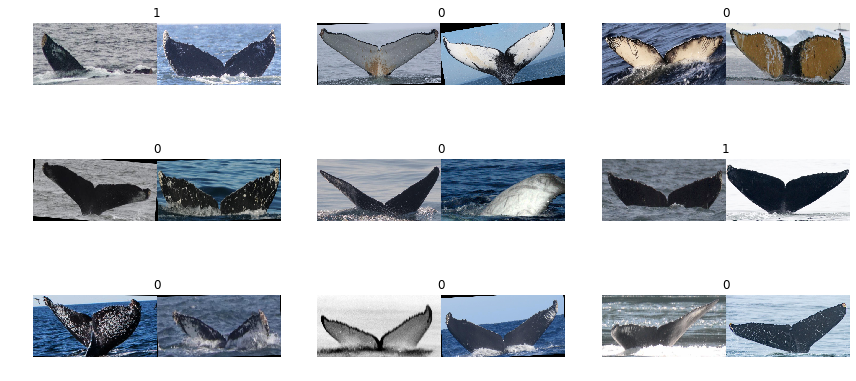

In [30]:
siamese_data.show_batch(rows=3, ds_type=DatasetType.Train)

## Model

In [26]:
# pair stats - calculate pair statistics of two vectors
def PairStats():
    return Lambda(lambda x: torch.cat([(x[0]+x[1]), 
                                       (x[0]*x[1]), 
                                       torch.abs(x[0]-x[1]), 
                                       torch.pow(x[0]-x[1], 2)], 0)
                  .reshape(x[0].shape[0], 4, 1, -1))

def AbsDiff():
    return Lambda(lambda x: torch.abs(x[0]-x[1]))

def SqDiff():
    return Lambda(lambda x: torch.pow(x[0]-x[1], 2))
                                       
# init siamese model
class SiameseModel(nn.Module):
    def __init__(self, cnn_head, cnn_body):
        super().__init__()
        self.cnn_body = cnn_body
        self.cnn_head = cnn_head
        
    def forward(self, img1, img2):
        x1 = self.cnn_body(img1)
        x2 = self.cnn_body(img2)
        return self.cnn_head([x1, x2])

In [27]:
# IMPROVE: Generate features using FCN block rather than AdaptivePooling Layers

# embedding extractor - extracts an embedding vector size of 4096
cnn_body = nn.Sequential(*[create_body(arch=models.resnet50, pretrained=True),
                           AdaptiveConcatPool2d(),
                           Flatten()])

# DEBUG: NOT CONVERGING FIX IT !
# pair scoring network - returns score to see if two embeddings are from matching classes
# cnn_head = nn.Sequential(*([PairStats(), conv2d(4,1,1, bias=True), nn.ReLU(), Flatten()] +
#                            list(create_head(1024, 1, lin_ftrs=[512], ps=0.0)[2:]) + 
#                            [nn.Sigmoid()]))


cnn_head = nn.Sequential(*([SqDiff()] + bn_drop_lin(4096, 1, bn=True, p=0.5)+
                           [nn.Sigmoid()]))

# construct siamese network    
apply_init(cnn_head, nn.init.kaiming_normal_)
siamese_model = SiameseModel(cnn_head, cnn_body)

# load pretrained backbone
# siamese_model.cnn_body[0] = pretrained_model[0]

## Training

Iterations of `siamese dataset generation` and `fit`

**Things to try:**

- Training with random bootstrapping:
    - while holdout validation doesn't improve:
        - Create siamese data
        - Fit with freeze_to(-1)
        - Fit with unfreeze()
        
        
- Training with adverserial bootstrapping:
    
    load previous model
    - while holdout validation doesn't improve:
        - Create siamese data
        - Fit with freeze_to(-1)
        - Fit with unfreeze()

In [32]:
print(pairs_df.shape); pairs_df.head(2)

(187576, 3)


,ImageA,ImageB,Is_Matched
0,2d3b18d76.jpg,461bf48f4.jpg,1
1,447b48dad.jpg,e1e3241a2.jpg,1


In [39]:
# create data
siamese_data = get_pair_data(pairs_df, size=(224,448), bs=32)

In [51]:
# creating learner for siamese network
learn = Learner(siamese_data, siamese_model)
splits = split_model_idx(learn.model, [57,-15]) # resnet50 split
learn.split(splits)

In [52]:
# define loss and accuracy
def loss_fn(input, target):
    return F.binary_cross_entropy(input.view(-1), target.float())

def accuracy_score(input, target, thresh=0.5):
    return torch.mean(((input > thresh).view(-1) == target.view(-1).byte()).float())

In [53]:
learn.load("siamese-v1.0.0-stage2")
learn.loss_func = loss_fn
acc_score = partial(accuracy_thresh, sigmoid=False)
learn.metrics = [accuracy_score]
learn.freeze_to(-1)

In [331]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


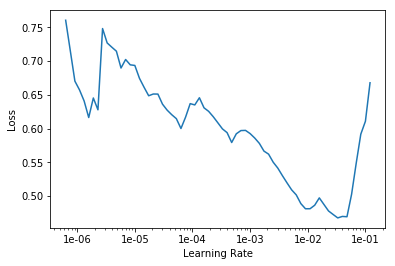

In [332]:
learn.recorder.plot()

In [59]:
early_stopping = EarlyStoppingCallback(learn, monitor='accuracy_score', mode='max', patience=10)

In [60]:
learn.callbacks.append(early_stopping)

In [ ]:
learn.fit_one_cycle(100, slice(5e-3))

epoch,train_loss,valid_loss,accuracy_score
1,0.221742,0.152656,0.942600
2,0.187420,0.130931,0.949600
3,0.181503,0.120744,0.955200
4,0.142546,0.104405,0.960600


In [ ]:
learn.save("siamese-v1.0.2-stage1")

In [ ]:
learn.fit_one_cycle(10, slice(5e-6))

In [ ]:
learn.save("siamese-v1.0.2-stage2")

In [54]:
validation = learn.validate(learn.data.valid_dl)

## Evaluation & Pred Generation

⚠️ HUGE BOTTLENECK FOR EACH EPOCH

- Maybe calculate every `nth` epoch by implementing a custom Learner Callback by passing empty every `n-1` epochs
- Find a way to incorporate evaluation into training fit

- Alternatively we can tune for threhold then make test preds

In [60]:
# original data
train_df.shape, training_df.shape, validation_df.shape

((25361, 2), (21338, 2), (4023, 2))

In [191]:
# sample validation to fasten the calcs
np.random.seed(42)
sample_validation_df = validation_df.sample(100).reset_index(drop=True)

# get all training and validation images
eval_valid_df = sample_validation_df
eval_train_df = training_df[training_df['Id'] != 'new_whale']
eval_train_df = eval_df.iloc[n_valid:].reset_index(drop=True)
eval_valid_df = eval_df.iloc[:n_valid].reset_index(drop=True)
eval_df = pd.concat([eval_valid_df, eval_train_df]).reset_index(drop=True)

print(f"new whale ratio: {np.mean(eval_valid_df.Id == 'new_whale')}")
print(f"total pair comparison to be made for validation: {len(eval_train_df)*len(eval_valid_df)}")
eval_df.shape, eval_train_df.shape, eval_valid_df.shape

new whale ratio: 0.25
total pair comparison to be made for validation: 1264000


((12740, 2), (12640, 2), (100, 2))

In [72]:
def get_eval_data(eval_df, eval_valid_df, sz=(112,224), bs=32):
    """
    get train, valid, test data for pairwise evaluation and final prediction
    Data configs should be same with actual training data, e.g. tfms, size, etc.
    tfms can act as TTA 
        - though it will be computationally expensize to get training embeddings many time
    """
    n_total = len(eval_df)
    n_valid = len(eval_valid_df)

    # create data for embedding computation
    itemlist = ImageItemList.from_df(eval_df, path=data_path, folder='cropped_training')
    itemlists = itemlist.split_by_idxs(train_idx=range(n_valid, n_total),
                                       valid_idx=range(0, n_valid))
    labellists = itemlists.label_const()
    labellists = labellists.add_test(ImageItemList.from_folder(path=data_path/'cropped_test'))
    data = (labellists.transform(get_transforms(p_affine=0, p_lighting=0, max_warp=0, max_zoom=0),
                                 size=sz,
                                 resize_method=ResizeMethod.SQUISH, 
                                 padding_mode='zeros')
                      .databunch(bs=bs))

    # make train data sampling sequential 
    data.train_dl = DeviceDataLoader(DataLoader(data.train_dl.dl.dataset,
                                                batch_size=data.train_dl.dl.batch_size,
                                                sampler=torch.utils.data.sampler.SequentialSampler(data.train_ds)),
                                                device=data.train_dl.device,
                                                tfms=data.train_dl.tfms,
                                                collate_fn=data.train_dl.collate_fn)
    return data

In [74]:
data = get_eval_data(eval_df, eval_valid_df)

In [109]:
import pdb
def predict_dl(model, dl): 
    pdb.set_trace()
    model = model.eval()
    preds = []
    with torch.no_grad():
        for xb, yb in tqdm_notebook(dl):
            preds.append(model(xb).cpu())
    return torch.cat(preds, dim=0)

In [80]:
train_embeddings = predict_dl(learn.model.cnn_body, data.train_dl)
valid_embeddings = predict_dl(learn.model.cnn_body, data.valid_dl)
test_embeddings = predict_dl(learn.model.cnn_body, data.test_dl)

In [83]:
train_embeddings.shape, valid_embeddings.shape, test_embeddings.shape

(torch.Size([12640, 4096]), torch.Size([100, 4096]), torch.Size([7960, 4096]))

In [85]:
# create pair idxs of embeddings valid x train
n_valid = len(valid_embeddings)
n_train = len(train_embeddings)
pair_idxs = []
for i in range(n_valid):
    for j in range(n_valid, n_valid + n_train):
        pair_idxs.append((i,j))

In [87]:
valid_train_embeddings = torch.cat([train_embeddings, valid_embeddings])

In [89]:
valid_train_embeddings.shape

torch.Size([12740, 4096])

In [107]:
# create pair dataset and dataloader for fast cost calculation
pair_ds = PairEmbeddingDataset(valid_train_embeddings, pair_idxs)
pair_dl = DataLoader(pair_ds, batch_size=2, shuffle=False, num_workers=8)

In [113]:
# compute scores - probability of being a matching pair
model = learn.model.cnn_head.eval()
similarity_score = []
with torch.no_grad(): # don't add these steps to computational graph
    for x1, x2 in tqdm_notebook(pair_dl):
        similarity_score.append(model([x1.cuda(), x2.cuda()]).cpu())

In [114]:
scores = torch.cat(similarity_score)

In [116]:
scores = scores.reshape((n_valid, n_train))

In [117]:
scores.shape, scores

(torch.Size([100, 12640]),
 tensor([[4.4609e-05, 5.2287e-06, 1.4498e-05,  ..., 1.6489e-01, 8.7301e-07,
          3.0590e-02],
         [6.7196e-05, 5.5569e-06, 9.4584e-08,  ..., 9.0259e-03, 8.3472e-07,
          7.1701e-03],
         [4.4905e-05, 3.3031e-03, 4.9010e-05,  ..., 2.2491e-06, 9.7296e-04,
          1.4651e-04],
         ...,
         [9.0903e-01, 2.9332e-07, 5.6880e-07,  ..., 3.7042e-09, 1.5894e-06,
          9.9881e-01],
         [1.8687e-06, 1.2164e-05, 4.8905e-01,  ..., 2.1259e-02, 3.1043e-09,
          3.0812e-03],
         [1.7333e-06, 3.2655e-09, 6.3779e-06,  ..., 4.0868e-05, 1.2134e-08,
          1.6450e-04]]))

In [119]:
scores.min(), scores.max()

(tensor(1.1297e-25), tensor(1.0000))

In [152]:
# get class labels
train_classes = eval_train_df['Id'].values
valid_classes = eval_valid_df['Id'].values

In [153]:
len(train_classes), len(valid_classes)

(12640, 100)

In [154]:
sorted_idxs = to_np(torch.argsort(scores, dim=1))[::-1]

In [172]:
sorted_idxs

array([[ 5154,  9497,  4829,  8058, ..., 12042,  4350,  1075,   469],
       [12514,  2212,  7338,  4665, ...,  3590, 10542,  7846, 12251],
       [ 6056,  9488,  9744,  1552, ..., 12573, 10834,  8182, 10910],
       [ 3715,   862,  1626, 10755, ...,  3490,  6485,  3248,   366],
       ...,
       [ 2212,  2024, 12514,  6792, ...,  5579,  5867,  3899,  5247],
       [11362, 10755,  5825,  1946, ...,  1180,  1224,  6876, 10643],
       [ 6560,  4665, 10687,  6518, ...,  7846,  2563,  6754,  5007],
       [11137,  4665,  7338,  2212, ...,  8614, 11548,  8202,  3325]])

In [173]:
sorted_classes = train_classes[sorted_idxs]

In [175]:
sorted_classes

array([['w_7648ac1', 'w_7b098ce', 'w_dc56028', 'w_6fe5b8e', ..., 'w_b2e75dc', 'w_f7d8d22', 'w_fd906cc', 'w_6fed7c4'],
       ['w_f0ba4a2', 'w_d6283ba', 'w_ecf39ca', 'w_3de579a', ..., 'w_0abe9e7', 'w_68eaf36', 'w_9b5109b', 'w_2af46a8'],
       ['w_faac069', 'w_9664ca8', 'w_780c931', 'w_c4b02b0', ..., 'w_5597026', 'w_b54f70f', 'w_edce644', 'w_12fdac7'],
       ['w_0ee7878', 'w_b71ac68', 'w_40acf40', 'w_9f13096', ..., 'w_21591ba', 'w_6ee9735', 'w_89f521e', 'w_171dc55'],
       ...,
       ['w_d6283ba', 'w_ba668da', 'w_f0ba4a2', 'w_27597ff', ..., 'w_281a8cd', 'w_c85ff1e', 'w_0a619af', 'w_ae393cd'],
       ['w_5802b33', 'w_9f13096', 'w_51e7506', 'w_7c77c5c', ..., 'w_1419d90', 'w_dd88965', 'w_f437f82', 'w_fd906cc'],
       ['w_25f1a4e', 'w_3de579a', 'w_2b069ba', 'w_e99ed06', ..., 'w_9b5109b', 'w_cbaa911', 'w_fc0cb69', 'w_091ec23'],
       ['w_fc6dd24', 'w_3de579a', 'w_ecf39ca', 'w_d6283ba', ..., 'w_2df85e7', 'w_b8e1687', 'w_a9304b9', 'w_d6d89ed']],
      dtype=object)

In [161]:
from utils import mapk

In [190]:
mapk(actual=valid_classes, predicted=sorted_classes, k=10000)

7.397156142923469e-05

In [186]:
# no match with any validation sample
sum(np.sum(sorted_classes == valid_classes[:, None], axis=1) < 1)

25

In [187]:
sum(np.sum(sorted_classes == valid_classes[:, None], axis=1) > 0)

75

### Visualize Top Macthes

In [245]:
def show_most_similar(i, sorted_idxs=sorted_idxs, eval_valid_df=eval_valid_df, eval_train_df=eval_train_df):
    """validate predictions by looking at top 5 most similar images"""
    actual_fn = eval_valid_df.iloc[i]['Image']
    actual_label = eval_valid_df.iloc[i]['Id']
    top5idxs = sorted_idxs[i, :5]

    most_similar_imgs = [(open_image(data_path/f'cropped_training/{fn}')) 
                         for fn in eval_train_df.iloc[top5idxs]['Image'].values]
    
    pred_labels =  eval_train_df.iloc[top5idxs]['Id'].values
    actual_img = (open_image(data_path/f'cropped_training/{actual_fn}'))

    fig, axes = plt.subplots(5, 2, figsize=(5*5, 2*5))
    for i, (ax, t) in enumerate(zip(axes, pred_labels)):
        actual_img.show(ax=ax[0], title=actual_label)
        most_similar_imgs[i].show(ax=ax[1], title=t)

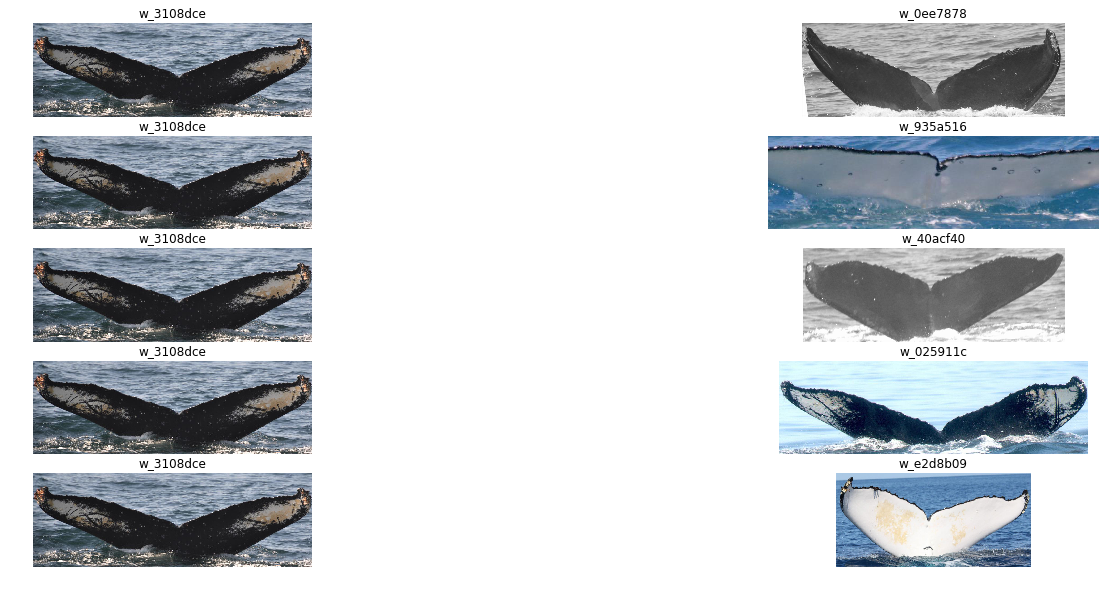

In [310]:
show_most_similar(16)

In [302]:
x1, x2 = valid_embeddings[0].cuda(), valid_embeddings[0].cuda()
# x1, x2 = valid_embeddings[0].cuda(), train_embeddings[0].cuda()

In [303]:
x1, x2

(tensor([0.0000, 3.4463, 2.4228,  ..., 0.5700, 1.0028, 0.0150], device='cuda:0'),
 tensor([0.0000, 3.4463, 2.4228,  ..., 0.5700, 1.0028, 0.0150], device='cuda:0'))

In [304]:
learn.model.cnn_head[:-1]

Sequential(
  (0): Lambda()
  (1): BatchNorm1d(4096, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): Dropout(p=0.5)
  (3): Linear(in_features=4096, out_features=1, bias=True)
)

In [305]:
learn.model.cnn_head([x1[None,:],x2[None, :]])

tensor([[1.0000]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [306]:
learn.model.cnn_head[:-1]([x1[None,:],x2[None, :]])

tensor([[11.7471]], device='cuda:0', grad_fn=<AddmmBackward>)